In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import argparse
import json
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from glob import glob
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
transform = transforms.Compose([
    lambda x: scaler.fit_transform(x),
    transforms.ToTensor()
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None, class_weights=None):
        self.data_dir = data_dir
        self.class_map = {"Lt_Apo_BPPV" : 0, "Lt_Geo_BPPV": 1, "Lt_PC_BPPV" : 2, "Rt_Apo_BPPV": 3, "Rt_Geo_BPPV" : 4, "Rt_PC_BPPV": 5}

        self.data = []
        classes = glob(self.data_dir + "/*")
        for class_path in classes:
            class_name = class_path.split("/")[-1]
            for filename in glob(class_path + "/*.*"):
                data = np.load(filename)
                if data.shape[0] < 100:
                    continue
                else:
                    if class_weights is not None:
                        class_weights /= np.max(class_weights)
                        if np.random.uniform() < class_weights[self.class_map[class_name]]:
                            self.data.append([filename, class_name])
                    else:
                        self.data.append([filename, class_name])
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def _add_noise(self, data):
        if np.random.uniform() < 0.5:
            noise = np.random.normal(0, 1, data.shape)
            data += noise
        return data
    
    def _random_shift(self, data):
        if np.random.uniform() < 0.8:
            data = np.roll(data, np.random.randint(100), axis=0)
        return data[:100, :]

    def __getitem__(self, index):
        filename, class_name = self.data[index]
        data = np.load(filename)
        vx = np.diff(data[:, 0], append=0).reshape(-1, 1)
        vy = np.diff(data[:, 1], append=0).reshape(-1, 1)
        data = np.concatenate((data, vx, vy), axis=1)
        data = self._add_noise(data)
        data = self._random_shift(data)
        data = self.transform(data).float()

        lr = torch.Tensor([0 if os.path.basename(filename)[13] == 'l' else 1])

        action = F.one_hot(torch.Tensor([int(os.path.basename(filename)[15]) - 1]).long(), 7)

        label = F.one_hot(torch.Tensor([self.class_map[class_name]]).long(), 6)

        return data.squeeze(), lr, action.squeeze(), label.squeeze()

In [ ]:
import collections
data_path = '/content/drive/MyDrive/Colab Notebooks/time_data'
dataset = CustomDataset(data_path, transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(0))

train_classes = [torch.argmax(label).cpu().detach().numpy().item() for _, _, _, label in train_dataset]
class_count = collections.Counter(train_classes)
class_count = collections.OrderedDict(sorted(class_count.items()))
class_weights = [max(class_count.values()) / v for k, v in class_count.items()]
class_weights[1] = 0
class_weights[0] = 0.3
print(class_count)

augmented_dataset = CustomDataset(data_path, transform, class_weights)
train_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_dataset])
train_classes = [torch.argmax(label).cpu().detach().numpy().item() for _, _, _, label in train_dataset]
class_count = collections.Counter(train_classes)
class_count = collections.OrderedDict(sorted(class_count.items()))
print(class_count)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

print(len(train_loader), len(val_loader), len(test_loader))

In [ ]:
class CNN1D(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.conv1 = nn.Conv1d(5, 64, 3, padding='same')
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(64, 128, 3, padding='same')
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(128, 64, 3, padding='same')
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(768 + 7 + 1, 256)
        self.fc3 = nn.Linear(256, out_features)

    def forward(self, data, lr, action):
        x = F.relu(self.conv1(data))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = torch.hstack([x, lr, action])
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x

In [ ]:
model_idx = 0

In [ ]:
model = CNN1D(6).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1000)

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

In [ ]:
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(32):
    train_loss = []
    accuracy = []
    model.train()
    for batch_id, (data, lr, action, label) in enumerate(tqdm(train_loader)):
        with torch.set_grad_enabled(True):
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            batch_size = data.size(0)
            data, label = data.to(device), label.float().to(device)
            lr, action = lr.to(device), action.to(device)
            data = data.transpose(1, 2)

            optimizer.zero_grad()

            outputs = model(data, lr, action)

            loss = loss_fn(outputs, label)

            loss.backward(retain_graph=True)
            optimizer.step()
            scheduler.step(epoch + batch_id / len(train_loader))

            train_loss.append(loss.item())
            y_pred = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            y_label = torch.argmax(label, dim=1).cpu().detach().numpy()

            accuracy.append(accuracy_score(y_pred, y_label))

    train_losses.append(np.mean(train_loss))
    train_acc.append(np.mean(accuracy))

    val_loss = []
    accuracy = []
    model.eval()
    for batch_id, (data, lr, action, label) in enumerate(tqdm(val_loader)):
        with torch.set_grad_enabled(False):
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            batch_size = data.size(0)
            data, label = data.to(device), label.float().to(device)
            lr, action = lr.to(device), action.to(device)
            data = data.transpose(1, 2)

            outputs = model(data, lr, action)

            loss = loss_fn(outputs, label)
            val_loss.append(loss.item())
            y_pred = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            y_label = torch.argmax(label, dim=1).cpu().detach().numpy()
            accuracy.append(accuracy_score(y_pred, y_label))
            
    val_losses.append(np.mean(val_loss))
    val_acc.append(np.mean(accuracy))
    
torch.save(model.state_dict(), f'./model_{model_idx}.pth')

model_idx += 1

100%|██████████| 11/11 [00:00<00:00, 26.38it/s]


In [ ]:
torch.save(model.state_dict(), f'./model_{model_idx}.pth')

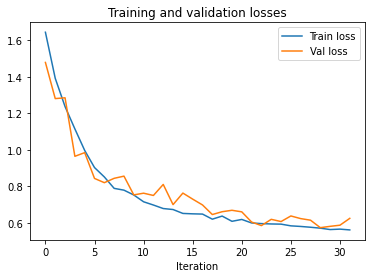

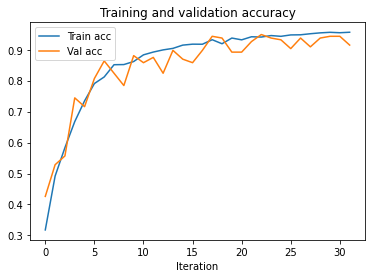

In [ ]:
plt.figure()
plt.title('Training and validation losses')
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(train_acc, label='Train acc')
plt.plot(val_acc, label='Val acc')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [ ]:
def classification_metrics(y_true, y_pred, binary=True):
    conf_mat = confusion_matrix(y_true, y_pred)

    if binary:
        acc = accuracy_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
    else:
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

    return conf_mat, accuracy, recall, precision, f1

In [ ]:
def test_model_on_dataset(model, dataset_loader, device='cuda'):
    y_pred = []
    y_label = []

    model.eval()
    with torch.no_grad():
        for batch_id, (data, lr, action, label) in enumerate(tqdm(dataset_loader)):
            batch_size = data.size(0)
            data, label = data.to(device), label.float().to(device)
            lr, action = lr.to(device), action.to(device)
            data = data.transpose(1, 2)

            outputs = model(data, lr, action)

            y_pred.extend(torch.argmax(outputs, dim=1).cpu().detach().numpy())
            y_label.extend(torch.argmax(label, dim=1).cpu().detach().numpy())

    return classification_metrics(y_label, y_pred, False)

In [ ]:
NUM_MODELS = 9
model_paths = [f'./model_{i}.pth' for i in range(NUM_MODELS)]

In [ ]:
for j, model_path in enumerate(model_paths):
    state_dict = torch.load(model_path)
    model = CNN1D(6).to(device)
    model.load_state_dict(state_dict)
    conf_mat, accuracy, recall, precision, f1 = test_model_on_dataset(model, test_loader)

    with open('individual_model_results.json', 'a+') as f:
        results = {'model_name': f'model_{j}', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
        f.write(json.dumps(results) + '\n')


100%|██████████| 31/31 [00:01<00:00, 25.21it/s]


In [ ]:
for j, model_path in enumerate(model_paths):
    assert os.path.exists(model_path)
    state_dict = torch.load(model_path)

    if j == 0:
        uniform_soup = {k : v * (1./NUM_MODELS) for k, v in state_dict.items()}
    else:
        uniform_soup = {k : v * (1./NUM_MODELS) + uniform_soup[k] for k, v in state_dict.items()}
    
model = CNN1D(6).to(device)
model.load_state_dict(uniform_soup)
conf_mat, accuracy, recall, precision, f1 = test_model_on_dataset(model, test_loader)
with open('soup_results.json', 'a+') as f:
    results = {'model_name': f'uniform_soup', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
    f.write(json.dumps(results) + '\n')

100%|██████████| 31/31 [00:01<00:00, 25.26it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import operator

# Sort models by decreasing accuracy on the held-out validation set
individual_model_db = pd.read_json('individual_model_results.json', lines=True)
individual_model_val_accs = {}
for _, row in individual_model_db.iterrows():
    individual_model_val_accs[row['model_name']] = row['accuracy']
individual_model_val_accs = sorted(individual_model_val_accs.items(), key=operator.itemgetter(1), reverse=True)
sorted_models = [x[0] for x in individual_model_val_accs]

greedy_soup_ingredients = [sorted_models[0]]
greedy_soup_params = torch.load(f'./{sorted_models[0]}.pth')
best_val_acc_so_far = individual_model_val_accs[0][1]

# Now, iterate through all models and consider adding them to the greedy soup
for i in range(1, NUM_MODELS - 1):
    new_ingredient_params = torch.load(f'./{sorted_models[i]}.pth')
    num_ingredients = len(greedy_soup_ingredients)
    potential_greedy_soup_params = {
        k : greedy_soup_params[k].clone() * (num_ingredients / (num_ingredients + 1.)) + 
            new_ingredient_params[k].clone() * (1. / (num_ingredients + 1))
        for k in new_ingredient_params
    }

    # Run the potential greedy soup on the held-out val set
    model = CNN1D(6).to(device)
    model.load_state_dict(potential_greedy_soup_params)
    _, held_out_val_accuracy, _, _, _ = test_model_on_dataset(model, val_loader)

    # If accuracy on the held-out val set increases, add the new model to the greedy soup.
    print(f'Potential greedy soup val acc {held_out_val_accuracy}, best so far {best_val_acc_so_far}.')
    if held_out_val_accuracy > best_val_acc_so_far:
        greedy_soup_ingredients.append(sorted_models[i])
        best_val_acc_so_far = held_out_val_accuracy
        greedy_soup_params = potential_greedy_soup_params
        print(f'Adding to soup. New soup is {greedy_soup_ingredients}')

model = CNN1D(6).to(device)
model.load_state_dict(greedy_soup_params)
conf_mat, accuracy, recall, precision, f1 = test_model_on_dataset(model, test_loader)

with open('soup_results.json', 'a+') as f:
    results = {'model_name': f'greedy_soup', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
    f.write(json.dumps(results) + '\n')

100%|██████████| 11/11 [00:00<00:00, 26.94it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Potential greedy soup val acc 0.21951219512195122, best so far 0.858870967741935.


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Potential greedy soup val acc 0.1951219512195122, best so far 0.858870967741935.


100%|██████████| 11/11 [00:00<00:00, 26.12it/s]


Potential greedy soup val acc 0.2073170731707317, best so far 0.858870967741935.


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Potential greedy soup val acc 0.17682926829268292, best so far 0.858870967741935.


100%|██████████| 11/11 [00:00<00:00, 25.95it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Potential greedy soup val acc 0.21341463414634146, best so far 0.858870967741935.


100%|██████████| 11/11 [00:00<00:00, 26.50it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Potential greedy soup val acc 0.22560975609756098, best so far 0.858870967741935.


100%|██████████| 11/11 [00:00<00:00, 27.26it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Potential greedy soup val acc 0.23170731707317074, best so far 0.858870967741935.


100%|██████████| 31/31 [00:01<00:00, 25.35it/s]


0.8689516129032258 0.8689516129032258 0.8800444559272435 0.8693184371556696


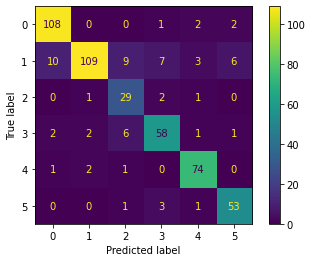

In [ ]:
print(accuracy, recall, precision, f1)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

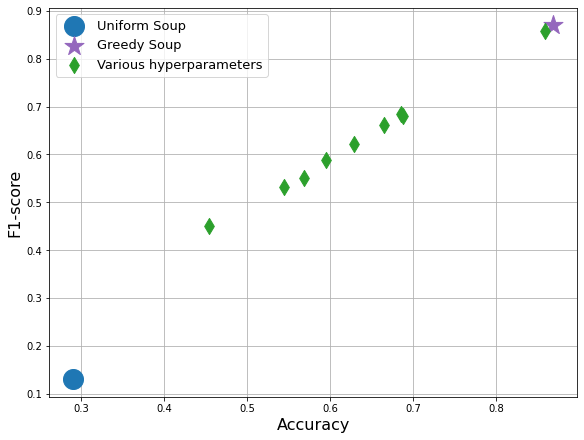

In [ ]:
individual_model_db = pd.read_json('individual_model_results.json', lines=True)
soup_model_db = pd.read_json('soup_results.json', lines=True)

fig = plt.figure(constrained_layout=True, figsize=(8, 6))
ax = fig.subplots()
ax.scatter(soup_model_db['accuracy'].values[0], soup_model_db['f1'].values[0], 
           marker='o', color='C0', s=400, label='Uniform Soup', zorder=10)

ax.scatter(soup_model_db['accuracy'].values[1], soup_model_db['f1'].values[1], 
           marker='*', color='C4', s=400, label='Greedy Soup', zorder=10)

ax.scatter(individual_model_db['accuracy'], individual_model_db['f1'], 
           marker='d', color='C2', s=130, label='Various hyperparameters', zorder=10)

ax.set_ylabel('F1-score', fontsize=16)
ax.set_xlabel('Accuracy', fontsize=16)
ax.grid()
ax.legend(fontsize=13)
plt.show()